# Módulo 05 - Detecção de Objetos coom YOLOv8

Neste módulo de introdução às técnicas de Processamento de Imagem, você vai conhecer os fundamentos da manipulação da imagem, além de desenvolver projetos como chroma keying e detecção de desmatamento a partir de imagens de satélites.

---

Os exemplos foram construídos com base nos materiais disponibilizados pela Roboflow, através do tutorial de Piotr Skalski disponível em [roboflow/notebooks.](https://github.com/roboflow/notebooks/tree/main?tab=readme-ov-file)

In [ ]:
!nvidia-smi

Tue Jan 23 23:21:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Instalar Ultralytics (YOLOv8)

In [1]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
print(ultralytics.checks())

Ultralytics YOLOv8.1.15 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)
None


In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M3UuH3QNDWGiH0NmGgHtIgXXGDo_nigm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1M3UuH3QNDWGiH0NmGgHtIgXXGDo_nigm" -O mall.mp4 && rm -rf /tmp/cookies.txt

display.clear_output()

!ls

mall.mp4


In [4]:
MALL_PATH = "mall.mp4"

In [5]:
import cv2
import numpy as np
from ultralytics import YOLO

# 1. Criar Modelo
model = YOLO("yolov8s.pt")

In [6]:
!pip install supervision
display.clear_output()

import supervision as sv
print("Supervision", sv.__version__)

Supervision 0.18.0


In [7]:
import cv2
import numpy as np
from ultralytics import YOLO

# 1. Criar Modelo
model = YOLO("yolov8s.pt")

In [8]:
generator = sv.get_video_frames_generator(MALL_PATH)

frame = next(generator)
# cv2.imwrite("frame_reference.jpg", frame)



0: 736x1280 1 person, 3 bottles, 1 chair, 2 tvs, 2 refrigerators, 27.7ms
Speed: 14.1ms preprocess, 27.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


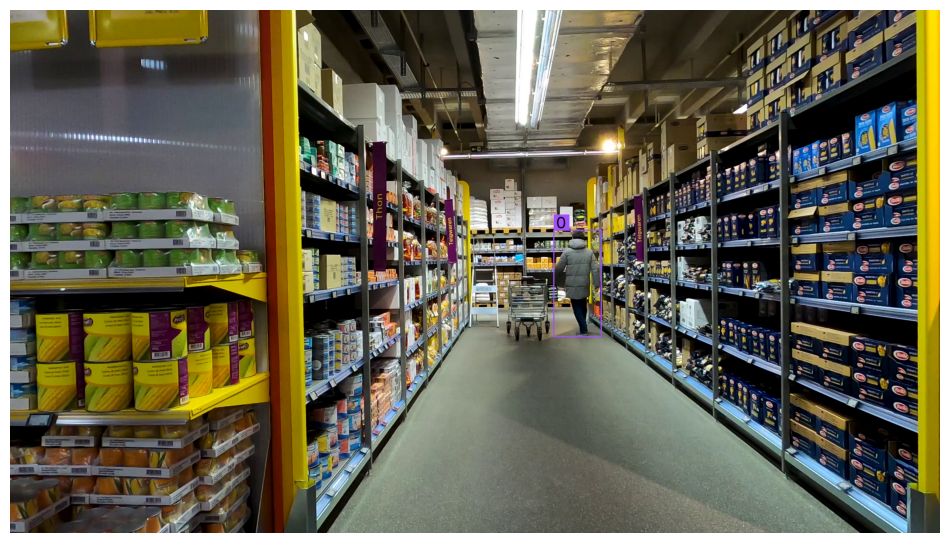

In [12]:
frame = next(generator)

# 2. Detectar objetos
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results) # para facilitar a sua vida e você sair com seu conjuge
detections = detections[detections.class_id == 0] # filtrando os resultados (apenas pessoas -> class_id == 0)

# 3 Anotar as informações relevantes
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2). # criando a minha anotação
box_annotator.annotate(scene=frame, detections=detections).  # de fato anoto em cima do frame (imagem)

%matplotlib inline
sv.plot_image(image=frame, size=(12, 12))

In [18]:
frame = next(generator)

# 1. Criar Modelo
model = YOLO("yolov8s.pt")

# 2. Detectar objetos
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results) # para facilitar a sua vida e você sair com seu cônjuge
detections = detections[detections.class_id == 0]


# 3. Anotar as informações relevantes

# 3.1 Criar zona de monitoramento
polygon = np.array([
    [1312, 2150],
    [1920, 1274],
    [2372, 1258],
    [3548, 2146],
    [1308, 2150]
    ])

# extrair informaçÕes do meu vídeo
video_info = sv.VideoInfo.from_video_path(video_path=MALL_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)


0: 736x1280 1 person, 3 bottles, 1 chair, 2 refrigerators, 12.0ms
Speed: 9.3ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


In [21]:
detections


Detections(xyxy=array([[     2239.3,      916.36,      2436.1,      1350.6]], dtype=float32), mask=None, confidence=array([     0.8999], dtype=float32), class_id=array([0]), tracker_id=None, data={})

<ipython-input-22-6a44cba893cc>:4: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)


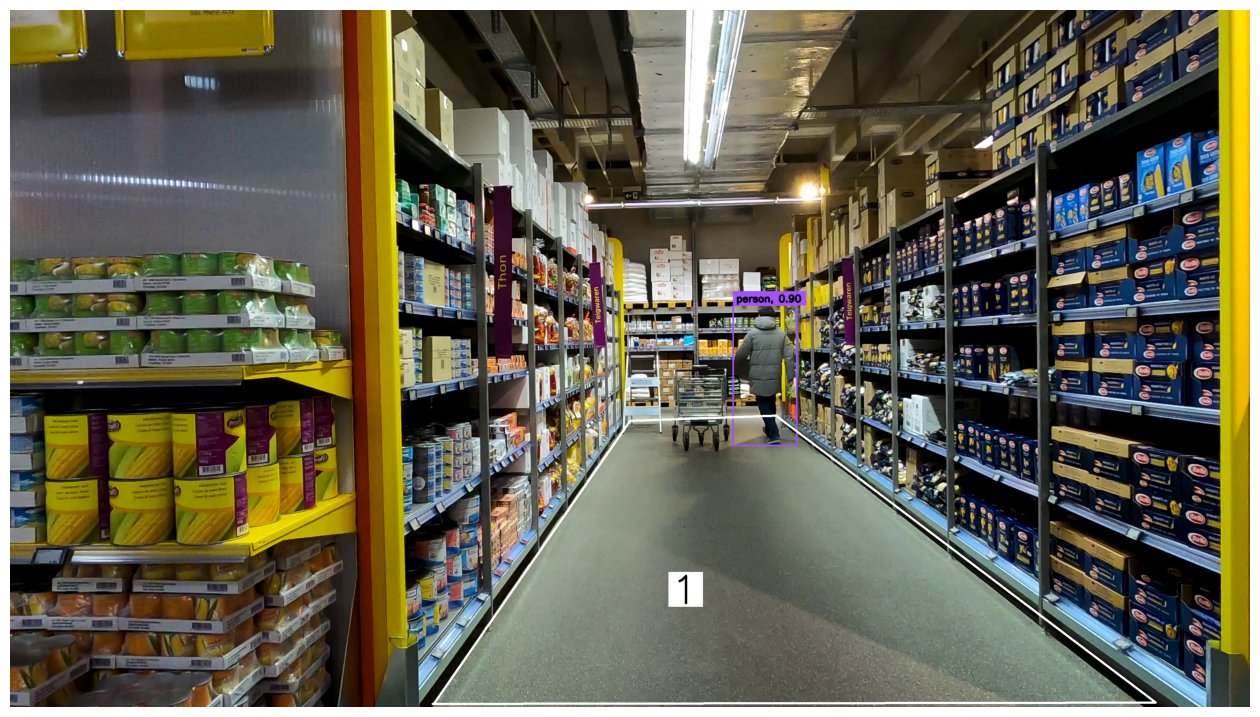

In [22]:
# criar objetos de anotações
labels = [f"{model.names[class_id]}, {confidence:0.2f}" for _, _, confidence, class_id, _ , _ in detections]

box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=1)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
zone.trigger(detections=detections)

box_annotator.annotate(scene=frame, detections=detections, labels=labels)
zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(image=frame, size=(16, 16))